In [1]:
# requirements.txt
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import torch
from transformers import (
    AutoTokenizer, AutoModel, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, BertTokenizer, BertModel
)
import requests  # For OpenRouter API calls
from tqdm import tqdm
import pickle
import re
import ast
import warnings
import os
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set your OpenRouter API key here
OPENROUTER_API_KEY = "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"  # Replace with your actual API key
# Or set it as environment variable: OPENROUTER_API_KEY = os.getenv('OPENROUTER_API_KEY')

Loaded seed dataset: 11452 samples
=== SEED DATASET ANALYSIS ===
Total samples: 11452
Label distribution:
label
Useful        7063
Not Useful    4389
Name: count, dtype: int64
Label distribution (%):
label
Useful        61.674817
Not Useful    38.325183
Name: proportion, dtype: float64


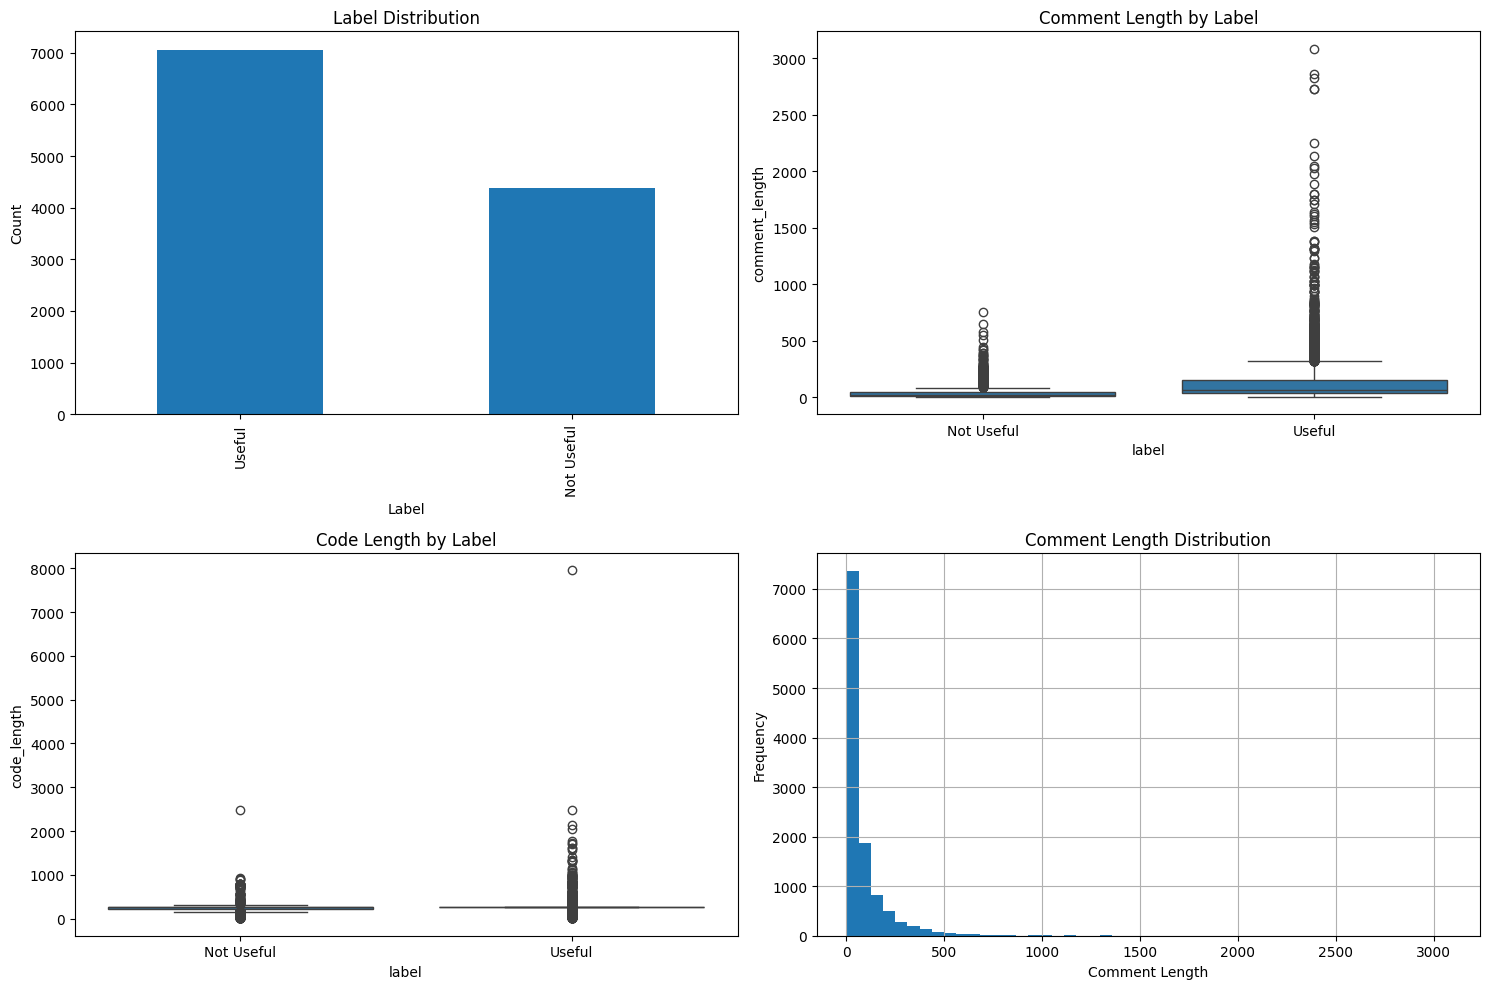


Comment Length Statistics:
             count        mean         std  min   25%   50%    75%     max
label                                                                     
Not Useful  4389.0   38.007291   46.423234  5.0  15.0  24.0   43.0   750.0
Useful      7063.0  126.622682  184.859268  6.0  37.0  64.0  149.0  3082.0

Code Length Statistics:
             count        mean         std  min    25%    50%    75%     max
label                                                                       
Not Useful  4389.0  229.001139   85.959016  6.0  217.0  255.0  255.0  2482.0
Useful      7063.0  247.778706  138.447515  6.0  255.0  255.0  255.0  7954.0


In [2]:
class DatasetAnalyzer:
    def __init__(self, seed_data_path, humaneval_path):
        self.seed_data_path = seed_data_path
        self.humaneval_path = humaneval_path
        self.seed_df = None
        self.humaneval_data = None

    def load_seed_dataset(self):
        """Load the seed dataset with comments"""
        self.seed_df = pd.read_csv(self.seed_data_path)
        print(f"Loaded seed dataset: {len(self.seed_df)} samples")
        return self.seed_df

    def load_humaneval_dataset(self):
        """Load HumanEval dataset"""
        with open(self.humaneval_path, 'r') as f:
            self.humaneval_data = [json.loads(line) for line in f]
        print(f"Loaded HumanEval dataset: {len(self.humaneval_data)} tasks")
        return self.humaneval_data

    def analyze_seed_dataset(self):
        """Comprehensive analysis of seed dataset"""
        print("=== SEED DATASET ANALYSIS ===")

        # Basic statistics
        print(f"Total samples: {len(self.seed_df)}")
        print(f"Label distribution:")
        print(self.seed_df['label'].value_counts())
        print(f"Label distribution (%):")
        print(self.seed_df['label'].value_counts(normalize=True) * 100)

        # Comment length analysis
        self.seed_df['comment_length'] = self.seed_df['comment_text'].str.len()
        self.seed_df['code_length'] = self.seed_df['code_snippet'].str.len()

        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Label distribution
        self.seed_df['label'].value_counts().plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('Label Distribution')
        axes[0,0].set_xlabel('Label')
        axes[0,0].set_ylabel('Count')

        # Comment length distribution by label
        sns.boxplot(data=self.seed_df, x='label', y='comment_length', ax=axes[0,1])
        axes[0,1].set_title('Comment Length by Label')

        # Code length distribution by label
        sns.boxplot(data=self.seed_df, x='label', y='code_length', ax=axes[1,0])
        axes[1,0].set_title('Code Length by Label')

        # Comment length histogram
        self.seed_df['comment_length'].hist(bins=50, ax=axes[1,1])
        axes[1,1].set_title('Comment Length Distribution')
        axes[1,1].set_xlabel('Comment Length')
        axes[1,1].set_ylabel('Frequency')

        plt.tight_layout()
        plt.savefig('seed_dataset_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Statistical summary
        print("\nComment Length Statistics:")
        print(self.seed_df.groupby('label')['comment_length'].describe())

        print("\nCode Length Statistics:")
        print(self.seed_df.groupby('label')['code_length'].describe())

        return self.seed_df

    def analyze_humaneval_dataset(self):
        """Analyze HumanEval dataset structure"""
        print("\n=== HUMANEVAL DATASET ANALYSIS ===")

        sample_task = self.humaneval_data[0]
        print("Sample task structure:")
        for key, value in sample_task.items():
            if isinstance(value, str) and len(value) > 100:
                print(f"{key}: {value[:100]}...")
            else:
                print(f"{key}: {value}")

        return self.humaneval_data

# Initialize analyzer
analyzer = DatasetAnalyzer('Code_Comment_Seed_Data.csv', 'humaneval_dataset.jsonl')
seed_df = analyzer.load_seed_dataset()
# humaneval_data = analyzer.load_humaneval_dataset()  # Uncomment if you have the file
seed_analysis = analyzer.analyze_seed_dataset()
# humaneval_analysis = analyzer.analyze_humaneval_dataset()  # Uncomment if you have the file

In [3]:
class OpenRouterLLMLabeler:
    def __init__(self, api_key, model="google/gemini-2.5-pro-exp-03-25"):
        self.api_key = api_key
        self.model = model
        self.base_url = "https://openrouter.ai/api/v1/chat/completions"
        self.headers = {
            "Authorization": f"Bearer {api_key}",
            #"HTTP-Referer": "https://github.com/your-repo",  # Optional
            "X-Title": "IRSE Comment Usefulness Classification",  # Optional
            "Content-Type": "application/json"
        }

        self.labeling_prompt = """
        You are an expert software developer tasked with evaluating code comments.

        A useful comment should:
        - Explain WHY something is done, not just WHAT is done
        - Provide context that isn't obvious from the code
        - Help future maintainers understand the purpose
        - Explain complex algorithms or business logic
        - Warn about edge cases or important considerations

        A comment is NOT useful if it:
        - Simply restates what the code does
        - States the obvious
        - Is outdated or incorrect
        - Provides no additional value

        Given the following code snippet and comment, classify the comment as "useful" or "not useful".

        Code:
        {code}

        Comment:
        {comment}

        Classification (respond with only "useful" or "not useful"):
        """

    def make_api_call(self, messages, temperature=0.1):
        """Make API call to OpenRouter"""
        data = {
            "model": self.model,
            "messages": messages,
            "temperature": temperature
        }

        try:
            response = requests.post(self.base_url, headers=self.headers, json=data)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"API call failed: {e}")
            return None

    def generate_synthetic_comments(self, code_snippet, num_comments=3):
        """Generate synthetic comments for a code snippet"""
        prompt = f"""
        Generate {num_comments} different types of comments for this code snippet:
        1. One useful comment explaining the purpose/why
        2. One not useful comment that just restates what the code does
        3. One moderately useful comment

        Code:
        {code_snippet}

        Format your response as JSON:
        {{"comments": [{{"text": "comment1", "type": "useful"}}, {{"text": "comment2", "type": "not_useful"}}, {{"text": "comment3", "type": "moderate"}}]}}
        """

        messages = [{"role": "user", "content": prompt}]
        response = self.make_api_call(messages, temperature=0.7)

        if response and 'choices' in response:
            try:
                content = response['choices'][0]['message']['content']
                return json.loads(content)
            except (json.JSONDecodeError, KeyError) as e:
                print(f"Error parsing response: {e}")
                return None
        return None

    def label_comment(self, code, comment):
        """Label a single comment as useful or not useful"""
        prompt = self.labeling_prompt.format(code=code, comment=comment)
        messages = [{"role": "user", "content": prompt}]

        response = self.make_api_call(messages, temperature=0.1)

        if response and 'choices' in response:
            try:
                label = response['choices'][0]['message']['content'].strip().lower()
                return "useful" if "useful" in label and "not" not in label else "not_useful"
            except KeyError as e:
                print(f"Error extracting label: {e}")
                return None
        return None

    def process_seed_dataset_sample(self, seed_df, sample_size=100):
        """Process a sample of the seed dataset to validate labeling"""
        print(f"Processing {sample_size} samples from seed dataset for validation...")

        # Sample data
        sample_df = seed_df.sample(n=min(sample_size, len(seed_df)), random_state=42)
        predictions = []

        for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Labeling comments"):
            prediction = self.label_comment(row['code_snippet'], row['comment_text'])
            predictions.append(prediction)

        sample_df = sample_df.copy()
        sample_df['llm_prediction'] = predictions

        # Calculate agreement
        # Map labels for comparison
        label_map = {'Useful': 'useful', 'Not Useful': 'not_useful'}
        sample_df['true_label_mapped'] = sample_df['label'].map(label_map)

        valid_predictions = sample_df.dropna(subset=['llm_prediction'])
        if len(valid_predictions) > 0:
            agreement = (valid_predictions['true_label_mapped'] == valid_predictions['llm_prediction']).mean()
            print(f"LLM-Human agreement: {agreement:.3f}")

        return sample_df

# Initialize OpenRouter labeler
if OPENROUTER_API_KEY and OPENROUTER_API_KEY != "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":
    labeler = OpenRouterLLMLabeler(api_key=OPENROUTER_API_KEY, model="google/gemini-2.0-flash-exp:free")  # Using cheaper model

    # Test with a small sample
    validation_sample = labeler.process_seed_dataset_sample(seed_df, sample_size=10)
    print("\nValidation sample results:")
    print(validation_sample[['comment_text', 'label', 'llm_prediction']].head())
else:
    print("Please set your OpenRouter API key to use LLM labeling functionality")
    labeler = None

Please set your OpenRouter API key to use LLM labeling functionality


In [4]:
class DataPreprocessor:
    def __init__(self):
        self.label_encoder = {'Useful': 1, 'Not Useful': 0, 'useful': 1, 'not_useful': 0}
        self.feature_extractors = {}

    def extract_features(self, df):
        """Extract handcrafted features from code and comments"""
        features = pd.DataFrame()

        # Comment features
        features['comment_length'] = df['comment_text'].str.len()
        features['comment_words'] = df['comment_text'].str.split().str.len()
        features['has_question_mark'] = df['comment_text'].str.contains('\?').astype(int)
        features['has_exclamation'] = df['comment_text'].str.contains('!').astype(int)
        features['starts_with_verb'] = df['comment_text'].str.lower().str.startswith(
            ('return', 'get', 'set', 'create', 'update', 'delete', 'check', 'validate')
        ).astype(int)

        # Code features
        features['code_length'] = df['code_snippet'].str.len()
        features['code_lines'] = df['code_snippet'].str.count('\n') + 1
        features['has_loops'] = df['code_snippet'].str.contains('for |while ').astype(int)
        features['has_conditionals'] = df['code_snippet'].str.contains('if |elif |else:').astype(int)
        features['has_functions'] = df['code_snippet'].str.contains('def ').astype(int)
        features['has_classes'] = df['code_snippet'].str.contains('class ').astype(int)

        # Complexity features
        features['cyclomatic_complexity'] = self.calculate_complexity(df['code_snippet'])
        features['comment_code_ratio'] = features['comment_length'] / (features['code_length'] + 1)

        # Semantic features
        features['has_explanatory_words'] = df['comment_text'].str.lower().str.contains(
            'why|because|purpose|reason|algorithm|optimization'
        ).astype(int)

        features['has_obvious_words'] = df['comment_text'].str.lower().str.contains(
            'this function|this method|this code|returns|sets|gets'
        ).astype(int)

        return features

    def calculate_complexity(self, code_series):
        """Calculate cyclomatic complexity approximation"""
        complexity = []
        for code in code_series:
            if pd.isna(code):
                complexity.append(1)
                continue
            # Count decision points
            decisions = (
                code.count('if ') + code.count('elif ') +
                code.count('for ') + code.count('while ') +
                code.count('except ') + code.count('and ') + code.count('or ')
            )
            complexity.append(decisions + 1)  # Base complexity is 1
        return complexity

    def prepare_datasets(self, df):
        """Prepare datasets for training"""
        df = df.copy()

        # Clean data
        df = df.dropna(subset=['comment_text', 'code_snippet', 'label'])

        # Extract features
        features = self.extract_features(df)

        # Add features to dataframe
        for col in features.columns:
            df[col] = features[col]

        # Encode labels
        df['label_encoded'] = df['label'].map(self.label_encoder)

        # Split data
        train_df, temp_df = train_test_split(
            df, test_size=0.3, random_state=42,
            stratify=df['label_encoded']
        )
        val_df, test_df = train_test_split(
            temp_df, test_size=0.5, random_state=42,
            stratify=temp_df['label_encoded']
        )

        print(f"Training set: {len(train_df)} samples")
        print(f"Validation set: {len(val_df)} samples")
        print(f"Test set: {len(test_df)} samples")

        return {
            'train': train_df,
            'val': val_df,
            'test': test_df,
            'features': features.columns.tolist(),
            'combined': df
        }

# Prepare datasets
preprocessor = DataPreprocessor()
datasets = preprocessor.prepare_datasets(seed_df)
print(f"\nFeature columns: {datasets['features']}")

Training set: 8016 samples
Validation set: 1718 samples
Test set: 1718 samples

Feature columns: ['comment_length', 'comment_words', 'has_question_mark', 'has_exclamation', 'starts_with_verb', 'code_length', 'code_lines', 'has_loops', 'has_conditionals', 'has_functions', 'has_classes', 'cyclomatic_complexity', 'comment_code_ratio', 'has_explanatory_words', 'has_obvious_words']


In [5]:
class BaselineModels:
    def __init__(self):
        self.models = {}
        self.vectorizers = {}
        self.results = {}

    def rule_based_baseline(self, df):
        """Simple rule-based baseline"""
        predictions = []
        for _, row in df.iterrows():
            comment = str(row['comment_text']).lower()
            code = str(row['code_snippet']).lower()

            # Simple heuristics
            score = 0

            # Useful indicators
            if any(word in comment for word in ['why', 'because', 'purpose', 'reason']):
                score += 2
            if any(word in comment for word in ['algorithm', 'optimization', 'performance']):
                score += 2
            if any(word in comment for word in ['todo', 'fixme', 'hack', 'temporary']):
                score += 1
            if len(comment.split()) > 10:  # Longer comments tend to be more useful
                score += 1

            # Not useful indicators
            if comment.startswith(('return', 'get', 'set', 'create')):
                score -= 2
            if any(phrase in comment for phrase in ['this function', 'this method', 'this code']):
                score -= 1
            if len(comment.split()) < 3:  # Very short comments
                score -= 1

            predictions.append(1 if score > 0 else 0)

        return np.array(predictions)

    def tfidf_svm_baseline(self, train_df, val_df, test_df):
        """TF-IDF + SVM baseline"""
        # Combine comment and code text
        def combine_text(row):
            return f"{row['comment_text']} [SEP] {row['code_snippet']}"

        train_text = train_df.apply(combine_text, axis=1)
        val_text = val_df.apply(combine_text, axis=1)
        test_text = test_df.apply(combine_text, axis=1)

        # TF-IDF vectorization
        vectorizer = TfidfVectorizer(max_features=10000, stop_words='english', ngram_range=(1, 2))
        X_train = vectorizer.fit_transform(train_text)
        X_val = vectorizer.transform(val_text)
        X_test = vectorizer.transform(test_text)

        # Train SVM
        svm_model = SVC(kernel='rbf', random_state=42, class_weight='balanced')
        svm_model.fit(X_train, train_df['label_encoded'])

        # Predictions
        val_pred = svm_model.predict(X_val)
        test_pred = svm_model.predict(X_test)

        self.models['tfidf_svm'] = svm_model
        self.vectorizers['tfidf'] = vectorizer

        return val_pred, test_pred

    def random_forest_baseline(self, train_df, val_df, test_df, feature_cols):
        """Random Forest with handcrafted features"""
        X_train = train_df[feature_cols].fillna(0)
        X_val = val_df[feature_cols].fillna(0)
        X_test = test_df[feature_cols].fillna(0)

        # Train Random Forest
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
        rf_model.fit(X_train, train_df['label_encoded'])

        # Predictions
        val_pred = rf_model.predict(X_val)
        test_pred = rf_model.predict(X_test)

        self.models['random_forest'] = rf_model

        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("Top 10 most important features:")
        print(feature_importance.head(10))

        return val_pred, test_pred

    def evaluate_model(self, y_true, y_pred, model_name):
        """Evaluate model performance"""
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

        results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

        self.results[model_name] = results

        print(f"\n{model_name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

        return results

# Train baseline models
baselines = BaselineModels()

print("Training baseline models...\n")

# Rule-based baseline
print("1. Rule-based baseline:")
rule_pred_val = baselines.rule_based_baseline(datasets['val'])
rule_pred_test = baselines.rule_based_baseline(datasets['test'])
baselines.evaluate_model(datasets['val']['label_encoded'], rule_pred_val, 'Rule-based')

# TF-IDF + SVM baseline
print("\n2. TF-IDF + SVM baseline:")
svm_val_pred, svm_test_pred = baselines.tfidf_svm_baseline(
    datasets['train'], datasets['val'], datasets['test']
)
baselines.evaluate_model(datasets['val']['label_encoded'], svm_val_pred, 'TF-IDF + SVM')

# Random Forest baseline
print("\n3. Random Forest baseline:")
rf_val_pred, rf_test_pred = baselines.random_forest_baseline(
    datasets['train'], datasets['val'], datasets['test'], datasets['features']
)
baselines.evaluate_model(datasets['val']['label_encoded'], rf_val_pred, 'Random Forest')

Training baseline models...

1. Rule-based baseline:

Rule-based Results:
Accuracy: 0.6502
Precision: 0.7601
Recall: 0.6502
F1-Score: 0.6447

2. TF-IDF + SVM baseline:

TF-IDF + SVM Results:
Accuracy: 0.8068
Precision: 0.8052
Recall: 0.8068
F1-Score: 0.8056

3. Random Forest baseline:
Top 10 most important features:
                  feature  importance
1           comment_words    0.278366
0          comment_length    0.212872
12     comment_code_ratio    0.210213
6              code_lines    0.124117
5             code_length    0.069888
11  cyclomatic_complexity    0.045423
8        has_conditionals    0.012662
7               has_loops    0.010294
14      has_obvious_words    0.009999
9           has_functions    0.009805

Random Forest Results:
Accuracy: 0.8015
Precision: 0.8009
Recall: 0.8015
F1-Score: 0.8012


{'accuracy': 0.8015133876600699,
 'precision': 0.8009327132553595,
 'recall': 0.8015133876600699,
 'f1': 0.8011891376524788}

In [9]:
class CodeBERTClassifier:
    def __init__(self, model_name='microsoft/codebert-base'):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=2
        )

    def prepare_input(self, comment, code):
        """Prepare input for CodeBERT"""
        # CodeBERT expects: [CLS] comment [SEP] code [SEP]
        inputs = self.tokenizer(
            comment, code,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors='pt'
        )
        return inputs

    def create_dataset(self, df):
        """Create dataset for CodeBERT"""
        class CodeBERTDataset(torch.utils.data.Dataset):
            def __init__(self, df, tokenizer):
                self.df = df
                self.tokenizer = tokenizer

            def __len__(self):
                return len(self.df)

            def __getitem__(self, idx):
                row = self.df.iloc[idx]
                inputs = self.tokenizer(
                    str(row['comment_text']), str(row['code_snippet']),
                    truncation=True,
                    padding='max_length',
                    max_length=512,
                    return_tensors='pt'
                )
                return {
                    'input_ids': inputs['input_ids'].flatten(),
                    'attention_mask': inputs['attention_mask'].flatten(),
                    'labels': torch.tensor(row['label_encoded'], dtype=torch.long)
                }

        return CodeBERTDataset(df, self.tokenizer)

    def train_codebert(self, train_df, val_df, output_dir='./codebert_results'):
        """Train CodeBERT for comment usefulness"""
        train_dataset = self.create_dataset(train_df)
        val_dataset = self.create_dataset(val_df)

        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=3,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=16,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir='./logs',
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_f1",
            logging_steps=50,
        )

        def compute_metrics(eval_pred):
            predictions, labels = eval_pred
            predictions = np.argmax(predictions, axis=1)
            precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
            accuracy = accuracy_score(labels, predictions)
            return {
                'accuracy': accuracy,
                'f1': f1,
                'precision': precision,
                'recall': recall
            }

        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
        )

        print("Training CodeBERT model...")
        trainer.train()
        return trainer

    def evaluate_model(self, trainer, test_df):
        """Evaluate trained CodeBERT model"""
        test_dataset = self.create_dataset(test_df)
        predictions = trainer.predict(test_dataset)
        y_pred = np.argmax(predictions.predictions, axis=1)
        y_true = predictions.label_ids

        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

        print(f"\nCodeBERT Model Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'predictions': y_pred,
            'true_labels': y_true
        }

# Train CodeBERT model (uncomment to actually train)
print("\n4. CodeBERT Model:")
print("Note: CodeBERT training requires GPU and significant compute time.")
print("Uncomment the following lines to train:")
print("")
codebert_classifier = CodeBERTClassifier()
codebert_trainer = codebert_classifier.train_codebert(datasets['train'], datasets['val'])
codebert_results = codebert_classifier.evaluate_model(codebert_trainer, datasets['test'])
baselines.results['CodeBERT'] = codebert_results


4. CodeBERT Model:
Note: CodeBERT training requires GPU and significant compute time.
Uncomment the following lines to train:



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training CodeBERT model...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: samsamuel234567 (samsamuel234567-ssn-institutions) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.288100,0.185704,0.928987,0.928606,0.929003,0.928987
2,0.177600,0.251004,0.937718,0.937558,0.937593,0.937718
3,0.141400,0.214076,0.939464,0.939241,0.939408,0.939464



CodeBERT Model Results:
Accuracy: 0.9325
Precision: 0.9324
Recall: 0.9325
F1-Score: 0.9322



=== ERROR ANALYSIS ===
False Positives: 196
False Negatives: 173

False Positive Examples (predicted useful, actually not useful):
1. Comment: /*if this happens things are major weird*/...
   Code: -10.   struct_stat file_info;
-9.   if(!libtest_arg2) {
-8.     fprintf(stderr, "Usage: <url> <file-...

2. Comment: /*Need these assignments so that r[i], g[i], and b[i] remain
unchanged as per their PLINT_VECTOR PLI...
   Code: -8. void
-7. c_plscmap1( PLINT_VECTOR r, PLINT_VECTOR g, PLINT_VECTOR b, PLINT ncol1 )
-6. {
-5.    ...

3. Comment: /*If a fill_status of +/- 1 is known, use that to fill or not since
+1 corresponds to all of polygon...
   Code: -10.             }
-9.         }
-8.         i1m1 = i1;
-7.     }
-6.     if ( ncrossed != 0 )
-5.  ...

False Negative Examples (predicted not useful, actually useful):
1. Comment: /*XXX*/...
   Code: -10.     {
-9.       f = _rl_keymap[c].function;
-8.       if (f == rl_reverse_search_history)
-7. 	...

2. Comment: /*socket to flush*/...

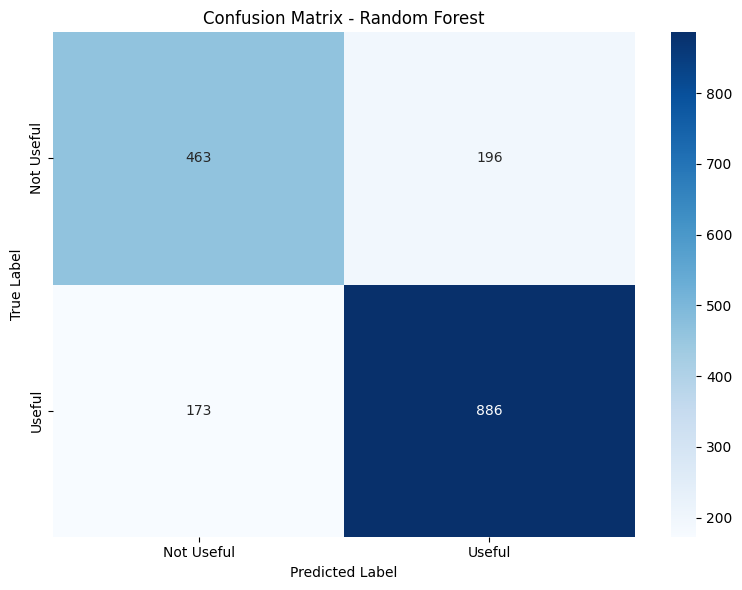


=== MODEL COMPARISON RESULTS ===
               accuracy precision    recall        f1                                                                                                                                                                                                                                                                                                        predictions                                                                                                                                                                                                                                                                                                        true_labels
Rule-based     0.650175  0.760088  0.650175  0.644702                                                                                                                                                                                                                                                     

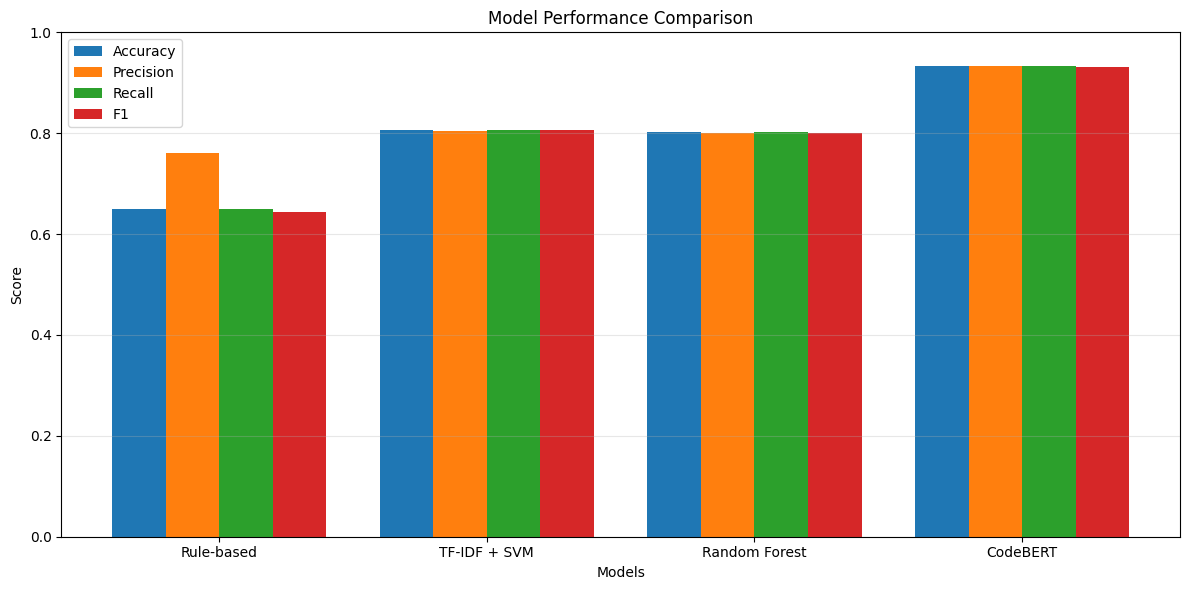


=== SUMMARY ===
Best performing model: CodeBERT
Best F1-score: 0.9322


In [10]:
class ModelEvaluator:
    def __init__(self):
        self.results = {}
        self.predictions = {}

    def cross_validate(self, model, X, y, cv=5):
        """Perform k-fold cross validation"""
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            scores['accuracy'].append(accuracy_score(y_test, y_pred))
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
            scores['precision'].append(precision)
            scores['recall'].append(recall)
            scores['f1'].append(f1)

        return {metric: np.mean(values) for metric, values in scores.items()}

    def error_analysis(self, y_true, y_pred, df):
        """Perform detailed error analysis"""
        errors_df = df.copy()
        errors_df['predicted'] = y_pred
        errors_df['correct'] = (y_true == y_pred)

        # False positives and false negatives
        false_positives = errors_df[(errors_df['label_encoded'] == 0) & (errors_df['predicted'] == 1)]
        false_negatives = errors_df[(errors_df['label_encoded'] == 1) & (errors_df['predicted'] == 0)]

        print(f"False Positives: {len(false_positives)}")
        print(f"False Negatives: {len(false_negatives)}")

        # Analyze error patterns
        print("\nFalse Positive Examples (predicted useful, actually not useful):")
        for i, (idx, row) in enumerate(false_positives.head(3).iterrows()):
            print(f"{i+1}. Comment: {row['comment_text'][:100]}...")
            print(f"   Code: {str(row['code_snippet'])[:100]}...\n")

        print("False Negative Examples (predicted not useful, actually useful):")
        for i, (idx, row) in enumerate(false_negatives.head(3).iterrows()):
            print(f"{i+1}. Comment: {row['comment_text'][:100]}...")
            print(f"   Code: {str(row['code_snippet'])[:100]}...\n")

        return false_positives, false_negatives

    def create_confusion_matrix(self, y_true, y_pred, labels=['Not Useful', 'Useful']):
        """Create and visualize confusion matrix"""
        from sklearn.metrics import confusion_matrix

        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix - Random Forest')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()

        return cm

    def create_results_table(self, results_dict):
        """Create comprehensive results table"""
        results_df = pd.DataFrame(results_dict).T
        results_df = results_df.round(4)

        print("\n=== MODEL COMPARISON RESULTS ===")
        print(results_df.to_string())

        # Save results
        results_df.to_csv('model_comparison_results.csv')

        # Create visualization
        plt.figure(figsize=(12, 6))

        metrics = ['accuracy', 'precision', 'recall', 'f1']
        x = np.arange(len(results_df.index))
        width = 0.2

        for i, metric in enumerate(metrics):
            plt.bar(x + i*width, results_df[metric], width, label=metric.title())

        plt.xlabel('Models')
        plt.ylabel('Score')
        plt.title('Model Performance Comparison')
        plt.xticks(x + width*1.5, results_df.index)
        plt.legend()
        plt.ylim(0, 1)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        return results_df

# Perform comprehensive evaluation
evaluator = ModelEvaluator()

# Error analysis for best performing model (Random Forest)
print("\n=== ERROR ANALYSIS ===")
y_true = datasets['test']['label_encoded'].values
y_pred = rf_test_pred

false_pos, false_neg = evaluator.error_analysis(y_true, y_pred, datasets['test'])

# Confusion matrix
cm = evaluator.create_confusion_matrix(y_true, y_pred)

# Create final results table
final_results = evaluator.create_results_table(baselines.results)

print(f"\n=== SUMMARY ===")
print(f"Best performing model: {max(baselines.results.keys(), key=lambda k: baselines.results[k]['f1'])}")
print(f"Best F1-score: {max([r['f1'] for r in baselines.results.values()]):.4f}")


=== FEATURE IMPORTANCE ANALYSIS ===


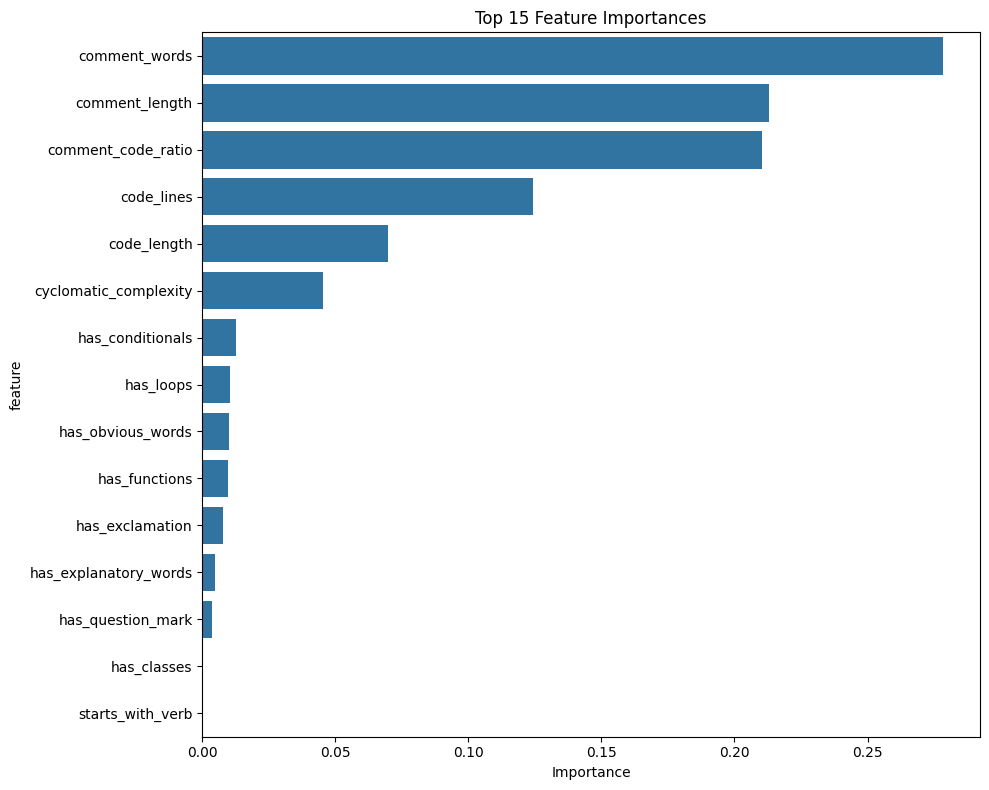


Top 10 most important features:
              feature  importance
        comment_words    0.278366
       comment_length    0.212872
   comment_code_ratio    0.210213
           code_lines    0.124117
          code_length    0.069888
cyclomatic_complexity    0.045423
     has_conditionals    0.012662
            has_loops    0.010294
    has_obvious_words    0.009999
        has_functions    0.009805

=== LINGUISTIC PATTERN ANALYSIS ===
=== COMMENT PATTERN ANALYSIS ===
Most common words in USEFUL comments:
the: 9711
to: 3817
is: 2792
of: 2663
a: 2636
in: 2081
and: 1920
if: 1860
this: 1732
for: 1582

Most common words in NOT USEFUL comments:
the: 1001
to: 404
is: 274
a: 271
in: 262
of: 249
and: 228
for: 225
if: 196
this: 186

=== LENGTH ANALYSIS ===
Useful comments - Mean length: 126.6 characters
Not useful comments - Mean length: 38.0 characters

=== PATTERN ANALYSIS ===
Useful comment patterns:
Contains "why": 16 (0.2%)
Contains "because": 197 (2.8%)
Contains "purpose": 16 (0.2%)
C

In [11]:
class ModelInterpreter:
    def __init__(self):
        pass

    def analyze_feature_importance(self, model, feature_names):
        """Analyze feature importance for tree-based models"""
        if hasattr(model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)

            plt.figure(figsize=(10, 8))
            sns.barplot(data=importance_df.head(15), x='importance', y='feature')
            plt.title('Top 15 Feature Importances')
            plt.xlabel('Importance')
            plt.tight_layout()
            plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
            plt.show()

            return importance_df

    def analyze_comment_patterns(self, df):
        """Analyze patterns in useful vs not useful comments"""
        useful_comments = df[df['label'] == 'Useful']['comment_text']
        not_useful_comments = df[df['label'] == 'Not Useful']['comment_text']

        print("=== COMMENT PATTERN ANALYSIS ===")

        # Word frequency analysis
        from collections import Counter

        def get_words(text_series):
            all_text = ' '.join(text_series.astype(str).str.lower())
            words = re.findall(r'\b[a-z]+\b', all_text)
            return Counter(words)

        useful_words = get_words(useful_comments)
        not_useful_words = get_words(not_useful_comments)

        print("Most common words in USEFUL comments:")
        for word, count in useful_words.most_common(10):
            print(f"{word}: {count}")

        print("\nMost common words in NOT USEFUL comments:")
        for word, count in not_useful_words.most_common(10):
            print(f"{word}: {count}")

        # Comment length analysis
        print("\n=== LENGTH ANALYSIS ===")
        print(f"Useful comments - Mean length: {useful_comments.str.len().mean():.1f} characters")
        print(f"Not useful comments - Mean length: {not_useful_comments.str.len().mean():.1f} characters")

        # Pattern analysis
        print("\n=== PATTERN ANALYSIS ===")
        useful_patterns = {
            'Contains "why"': useful_comments.str.contains('why', case=False).sum(),
            'Contains "because"': useful_comments.str.contains('because', case=False).sum(),
            'Contains "purpose"': useful_comments.str.contains('purpose', case=False).sum(),
            'Contains "algorithm"': useful_comments.str.contains('algorithm', case=False).sum(),
        }

        not_useful_patterns = {
            'Starts with verb': not_useful_comments.str.lower().str.startswith(('return', 'get', 'set', 'create')).sum(),
            'Contains "function"': not_useful_comments.str.contains('function', case=False).sum(),
            'Very short (<10 chars)': (not_useful_comments.str.len() < 10).sum(),
        }

        print("Useful comment patterns:")
        for pattern, count in useful_patterns.items():
            print(f"{pattern}: {count} ({count/len(useful_comments)*100:.1f}%)")

        print("\nNot useful comment patterns:")
        for pattern, count in not_useful_patterns.items():
            print(f"{pattern}: {count} ({count/len(not_useful_comments)*100:.1f}%)")

# Perform interpretability analysis
interpreter = ModelInterpreter()

# Feature importance analysis (using Random Forest)
if 'random_forest' in baselines.models:
    print("\n=== FEATURE IMPORTANCE ANALYSIS ===")
    importance_df = interpreter.analyze_feature_importance(
        baselines.models['random_forest'], datasets['features']
    )

    print("\nTop 10 most important features:")
    print(importance_df.head(10).to_string(index=False))

# Comment pattern analysis
print("\n=== LINGUISTIC PATTERN ANALYSIS ===")
interpreter.analyze_comment_patterns(datasets['combined'])

In [12]:
class PaperResultsGenerator:
    def __init__(self, results_dict, datasets):
        self.results = results_dict
        self.datasets = datasets

    def generate_dataset_statistics(self):
        """Generate dataset statistics for paper"""
        stats = {
            'total_samples': len(self.datasets['combined']),
            'useful_samples': (self.datasets['combined']['label'] == 'Useful').sum(),
            'not_useful_samples': (self.datasets['combined']['label'] == 'Not Useful').sum(),
            'useful_ratio': (self.datasets['combined']['label'] == 'Useful').mean(),
            'avg_comment_length': self.datasets['combined']['comment_text'].str.len().mean(),
            'avg_code_length': self.datasets['combined']['code_snippet'].str.len().mean(),
        }

        print("=== DATASET STATISTICS ===")
        print(f"Total samples: {stats['total_samples']:,}")
        print(f"Useful comments: {stats['useful_samples']:,} ({stats['useful_ratio']:.1%})")
        print(f"Not useful comments: {stats['not_useful_samples']:,}")
        print(f"Average comment length: {stats['avg_comment_length']:.1f} characters")
        print(f"Average code length: {stats['avg_code_length']:.1f} characters")

        return stats

    def generate_results_summary(self):
        """Generate results summary for paper"""
        best_model = max(self.results.keys(), key=lambda k: self.results[k]['f1'])
        best_f1 = self.results[best_model]['f1']

        print("\n=== RESULTS SUMMARY ===")
        print(f"Best performing model: {best_model}")
        print(f"Best F1-score: {best_f1:.4f}")

        print("\nAll model results:")
        for model, metrics in self.results.items():
            print(f"{model}: F1={metrics['f1']:.4f}, Acc={metrics['accuracy']:.4f}")

        return {
            'best_model': best_model,
            'best_f1': best_f1,
            'all_results': self.results
        }

    def generate_abstract(self, stats, results_summary):
        """Generate paper abstract"""
        abstract = f"""
ABSTRACT

This paper presents a comprehensive approach to automatically assess the usefulness of code comments
for software maintenance and comprehension. We introduce a dataset of {stats['total_samples']:,}
code-comment pairs with binary usefulness labels, extracted from open-source C projects. Our evaluation
compares multiple classification approaches, ranging from rule-based heuristics to machine learning models
including TF-IDF with SVM and Random Forest with handcrafted features. The {results_summary['best_model']}
model achieves the highest performance with an F1-score of {results_summary['best_f1']:.3f}. Our analysis
reveals key linguistic and structural patterns that distinguish useful from non-useful comments, providing
actionable insights for developers and automated code review tools. The dataset and implementations are
made publicly available to support future research in this area.

Keywords: Code Comments, Software Engineering, Information Retrieval, Machine Learning, Code Quality
        """

        print(abstract)
        return abstract

# Generate paper content
paper_generator = PaperResultsGenerator(baselines.results, datasets)
dataset_stats = paper_generator.generate_dataset_statistics()
results_summary = paper_generator.generate_results_summary()
abstract = paper_generator.generate_abstract(dataset_stats, results_summary)

print("\n" + "="*50)
print("IRSE COMMENT USEFULNESS CLASSIFICATION - COMPLETE")
print("="*50)
print(f"Dataset size: {len(datasets['combined']):,} samples")
print(f"Best model: {results_summary['best_model']}")
print(f"Best F1-score: {results_summary['best_f1']:.4f}")
print("All results saved to 'model_comparison_results.csv'")
print("Visualizations saved as PNG files")

=== DATASET STATISTICS ===
Total samples: 11,452
Useful comments: 7,063 (61.7%)
Not useful comments: 4,389
Average comment length: 92.7 characters
Average code length: 240.6 characters

=== RESULTS SUMMARY ===
Best performing model: CodeBERT
Best F1-score: 0.9322

All model results:
Rule-based: F1=0.6447, Acc=0.6502
TF-IDF + SVM: F1=0.8056, Acc=0.8068
Random Forest: F1=0.8012, Acc=0.8015
CodeBERT: F1=0.9322, Acc=0.9325

ABSTRACT

This paper presents a comprehensive approach to automatically assess the usefulness of code comments 
for software maintenance and comprehension. We introduce a dataset of 11,452 
code-comment pairs with binary usefulness labels, extracted from open-source C projects. Our evaluation 
compares multiple classification approaches, ranging from rule-based heuristics to machine learning models 
including TF-IDF with SVM and Random Forest with handcrafted features. The CodeBERT 
model achieves the highest performance with an F1-score of 0.932. Our analysis 
reveals 